## Теоретические выкладки

In [9]:
from sympy import *

C11, C12, C16, C22, C26, C66 = symbols('C11, C12, C16, C22, C26, C66')
C = Matrix([[C11, C12, C16],
           [C12, C22, C26],
           [C16, C26, C66]])
print("Matrix of conversion tensor, which connects tension (σ) and extensions (ε)")
display(C)
sigx, sigy, sigz = symbols('sigma_x sigma_y sigma_z')
sig = Matrix([sigx, sigy, sigz])
print("Vector of tension (σ):")
display(sig)
epsx, epsy, epsz = symbols('epsilon_x epsilon_y epsilon_z')
eps = Matrix([epsx, epsy, epsz])
print("Vector of extension (ε):")
display(eps)
Tensor_equation = Eq(sig, C*eps)
print("The matrix equation binding tension and extension")
display(Tensor_equation)
T = symbols('T')
init_printing(use_unicode=True)
nabla = symbols('U+2207')
display(nabla)

Matrix of conversion tensor, which connects tension (σ) and extensions (ε)


⎡C₁₁  C₁₂  C₁₆⎤
⎢             ⎥
⎢C₁₂  C₂₂  C₂₆⎥
⎢             ⎥
⎣C₁₆  C₂₆  C₆₆⎦

Vector of tension (σ):


⎡σₓ ⎤
⎢   ⎥
⎢σ_y⎥
⎢   ⎥
⎣σ_z⎦

Vector of extension (ε):


⎡εₓ ⎤
⎢   ⎥
⎢ε_y⎥
⎢   ⎥
⎣ε_z⎦

The matrix equation binding tension and extension


⎡σₓ ⎤   ⎡C₁₁⋅εₓ + C₁₂⋅ε_y + C₁₆⋅ε_z⎤
⎢   ⎥   ⎢                          ⎥
⎢σ_y⎥ = ⎢C₁₂⋅εₓ + C₂₂⋅ε_y + C₂₆⋅ε_z⎥
⎢   ⎥   ⎢                          ⎥
⎣σ_z⎦   ⎣C₁₆⋅εₓ + C₂₆⋅ε_y + C₆₆⋅ε_z⎦

In [10]:
from PIL import Image
image1 = Image.open('IMG_20210421_201044.jpg')
image2 = Image.open('IMG_20210421_201048.jpg')
image1.show()
image2.show()

The equation of equilibrium is such:
Solving all tensor equations we finish with matrixes Ax and Ay:
Ax =


⎡             -1         ⎤
⎢ 0      0    ───  0   0 ⎥
⎢              ρ         ⎥
⎢                        ⎥
⎢                     -1 ⎥
⎢ 0      0     0   0  ───⎥
⎢                      ρ ⎥
⎢                        ⎥
⎢      -C₁₆              ⎥
⎢-C₁₁  ─────   0   0   0 ⎥
⎢        2               ⎥
⎢                        ⎥
⎢      -C₂₆              ⎥
⎢-C₁₂  ─────   0   0   0 ⎥
⎢        2               ⎥
⎢                        ⎥
⎢      -C₆₆              ⎥
⎢-C₁₆  ─────   0   0   0 ⎥
⎣        2               ⎦

It has 5 eigenvalues:


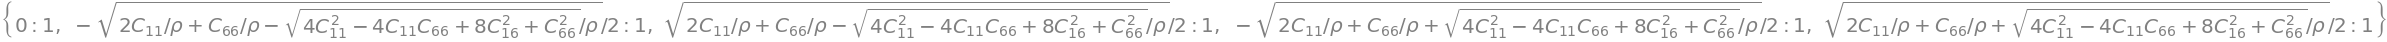

It has 5 eigenvectors.
Ay =


⎡                     -1 ⎤
⎢  0     0    0   0   ───⎥
⎢                      ρ ⎥
⎢                        ⎥
⎢                -1      ⎥
⎢  0     0    0  ───   0 ⎥
⎢                 ρ      ⎥
⎢                        ⎥
⎢-C₁₆                    ⎥
⎢─────  -C₁₂  0   0    0 ⎥
⎢  2                     ⎥
⎢                        ⎥
⎢-C₂₆                    ⎥
⎢─────  -C₂₂  0   0    0 ⎥
⎢  2                     ⎥
⎢                        ⎥
⎢-C₆₆                    ⎥
⎢─────  -C₂₆  0   0    0 ⎥
⎣  2                     ⎦

It has 5 eigenvalues:


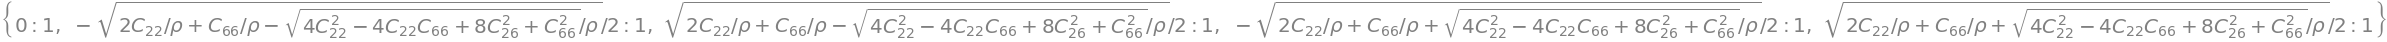

It has 5 eigenvectors.
Matrix of eigenvalues for X:


⎡       _______________________________________________________               
⎢      ╱                  ____________________________________                
⎢     ╱                  ╱      2                    2      2                 
⎢    ╱   2⋅C₁₁   C₆₆   ╲╱  4⋅C₁₁  - 4⋅C₁₁⋅C₆₆ + 8⋅C₁₆  + C₆₆                  
⎢-  ╱    ───── + ─── - ───────────────────────────────────────                
⎢ ╲╱       ρ      ρ                       ρ                                   
⎢───────────────────────────────────────────────────────────────              
⎢                               2                                             
⎢                                                                             
⎢                                                                       ______
⎢                                                                      ╱      
⎢                                                                     ╱       
⎢                                                   

Matrix of eigenvalues for Y:


⎡       _______________________________________________________               
⎢      ╱                  ____________________________________                
⎢     ╱                  ╱      2                    2      2                 
⎢    ╱   2⋅C₂₂   C₆₆   ╲╱  4⋅C₂₂  - 4⋅C₂₂⋅C₆₆ + 8⋅C₂₆  + C₆₆                  
⎢-  ╱    ───── + ─── - ───────────────────────────────────────                
⎢ ╲╱       ρ      ρ                       ρ                                   
⎢───────────────────────────────────────────────────────────────              
⎢                               2                                             
⎢                                                                             
⎢                                                                       ______
⎢                                                                      ╱      
⎢                                                                     ╱       
⎢                                                   

In [43]:
print("The equation of equilibrium is such:")
rho = Symbol('rho')
print("Solving all tensor equations we finish with matrixes Ax and Ay:")
A_x = Matrix([[0,    0,      -1/rho, 0, 0     ],
              [0,    0,      0,      0, -1/rho],
              [-C11, -C16/2, 0,      0, 0     ],
              [-C12, -C26/2, 0,      0, 0     ],
              [-C16, -C66/2, 0,      0, 0,    ]])
print("Ax =")
display(A_x)
l_x = A_x.eigenvals()
print("It has 5 eigenvalues:")
display(l_x)
e_x = A_x.eigenvects()
print("It has 5 eigenvectors.")
A_y = Matrix([[0,      0,    0, 0,      -1/rho],
              [0,      0,    0, -1/rho, 0     ],
              [-C16/2, -C12, 0, 0,      0     ],
              [-C26/2, -C22, 0, 0,      0     ],
              [-C66/2, -C26, 0, 0,      0,    ]])
print("Ay =")
display(A_y)
l_y = A_y.eigenvals()
print("It has 5 eigenvalues:")
display(l_y)
e_y = A_y.eigenvects()
print("It has 5 eigenvectors.")
ll_x = list(l_x.keys())
Lam_x = diag(ll_x[0], ll_x[1], ll_x[2], ll_x[3], ll_x[4])
ll_y = list(l_y.keys())
Lam_y = diag(ll_y[0], ll_y[1], ll_y[2], ll_y[3], ll_y[4])
print("Matrix of eigenvalues for X:")
display(Lam_x)
print("Matrix of eigenvalues for Y:")
display(Lam_y)

In [56]:
Om  = MatrixSymbol('Ω', 5, 5)
A  = MatrixSymbol('A', 5, 5)
Lam = MatrixSymbol('Λ', 5, 5)
ConversionEquation = Eq(A, Om * Lam * Om.inv())
print("The matrix equation of conversion between basises for linear transformation is such:")
display(ConversionEquation)
print("Omega_x^(-1) =")
Omega_x_inv = Matrix()
Omega_x_inv = Omega_x_inv.col_insert(0, e_x[0][2][0])
Omega_x_inv = Omega_x_inv.col_insert(1, e_x[1][2][0])
Omega_x_inv = Omega_x_inv.col_insert(2, e_x[2][2][0])
Omega_x_inv = Omega_x_inv.col_insert(3, e_x[3][2][0])
Omega_x_inv = Omega_x_inv.col_insert(4, e_x[4][2][0])
display(Omega_x_inv)
print("Omega_y^(-1) =")
Omega_y_inv = Matrix()
Omega_y_inv = Omega_y_inv.col_insert(0, e_y[0][2][0])
Omega_y_inv = Omega_y_inv.col_insert(1, e_y[1][2][0])
Omega_y_inv = Omega_y_inv.col_insert(2, e_y[2][2][0])
Omega_y_inv = Omega_y_inv.col_insert(3, e_y[3][2][0])
Omega_y_inv = Omega_y_inv.col_insert(4, e_y[4][2][0])
display(Omega_y_inv)
print("I would show inversed Omegas, but their inversion naturally takes inconsiderable time. So further I will use numerical expressions.")

The matrix equation of conversion between basises for linear transformation is such:


Omega_x^(-1) =


⎡                                                                   __________
⎢                                                                  ╱          
⎢                                                                 ╱           
⎢                                                                ╱   2⋅C₁₁   C
⎢                                                      -2⋅C₁₆⋅  ╱    ───── + ─
⎢                                                             ╲╱       ρ      
⎢0                                                    ────────────────────────
⎢                                                                             
⎢                                                                      2      
⎢                                                     2⋅C₁₁⋅C₆₆ - 4⋅C₁₆  - C₆₆
⎢                                                                             
⎢                                                                             
⎢0                                                  

Omega_y^(-1) =


⎡                                                                             
⎢0                                                        ────────────────────
⎢                                                                 ____________
⎢                                                                ╱            
⎢                                                               ╱             
⎢                                                              ╱   2⋅C₂₂   C₆₆
⎢                                                         ρ⋅  ╱    ───── + ───
⎢                                                           ╲╱       ρ      ρ 
⎢                                                                             
⎢                                                                   __________
⎢                                                                  ╱          
⎢                                                                 ╱           
⎢                                                   

Omega_x =
Omega_y =


## Библиотеки

In [60]:
import numpy as np
import matplotlib.pyplot as plt

## Функции

In [61]:
def fill_C(): #Заполнить сетку ненулевыми лямбдами
    C11 = 12.98344389516936
    C12 = 2.76656283641825
    C16 = 5.00630996992227
    C22 = 79.21121100901908
    C26 = 4.88188079023485
    C66 = 13.05325089362048
    C = np.array([(C11, C12, C16),
                  (C12, C22, C26),
                  (C16, C26, C66)])
    return C
            
def Omega(q):
    vx, vy, sxx, sxy = q
    return (np.sqrt(mu * rho) / 2.0 * vy + sxy / 2.0,
            -np.sqrt(mu * rho) / 2.0 * vy + sxy / 2.0,
            np.sqrt(rho * (lam + 2.0 * mu)) / 2.0 * vx + sxx / 2.0,
            -np.sqrt(rho * (lam + 2.0 * mu)) / 2.0 * vx + sxx / 2.0
           )

## Переменные

In [63]:
L = 1 # масштаб координатных осей
M = 51 # количество узлов вдоль оси
#C =  np.ones((3, 3)) # Сетка лямбд
C = fill_C()
print("Matrix C =", '\n', C)
rho = 1.0
h = L / M # шаг по координате, h
T = 1.5 * L / abs(np.max(C)) # 1 полный оборот начального возмущения
dt = 0.4 * h / abs(np.max(C)) # коэффициент должен быть меньше единицы
step_1 = C * dt / h # комбинация коэффициентов при шаге первого порядка
data_current = np.zeros((M, M), dtype=[('q', np.float64)])
data_next = np.zeros((M, M), dtype=[('q', np.float64)])

Matrix C = 
 [[12.9834439   2.76656284  5.00630997]
 [ 2.76656284 79.21121101  4.88188079]
 [ 5.00630997  4.88188079 13.05325089]]


## Численные вычисления матриц

In [77]:
import scipy.linalg as sci

In [103]:
Ax = np.array([[0,         0,         -1/rho, 0, 0     ],
               [0,         0,         0,      0, -1/rho],
               [-C[0][0], -C[0][2]/2, 0,      0, 0     ],
               [-C[0][1], -C[1][2]/2, 0,      0, 0     ],
               [-C[0][2], -C[2][2]/2, 0,      0, 0     ]])

Ay = np.array([[0,           0,       0, 0,      -1/rho],
               [0,           0,       0, -1/rho, 0     ],
               [-C[0][2]/2, -C[0][1], 0, 0,      0     ],
               [-C[1][2]/2, -C[1][1], 0, 0,      0     ],
               [-C[2][2]/2, -C[1][2], 0, 0,      0,    ]])
eigo_x = sci.eig(Ax) #Функция считает СВ и СЗ и сохраняет их в кортеж. Векторы в столбцы.
eigo_y = sci.eig(Ay)
Omegax_inv = eigo_x[1]
Omegay_inv = eigo_y[1]
Lamx = np.diag(eigo_x[0])
Lamx = Lamx.real #Берём действительную часть, мы же знаем, что у матрицы СЗ действительные
Lamy = np.diag(eigo_y[0])
Lamy = Lamy.real
Omegax = np.linalg.inv(Omegax_inv)
Omegay = np.linalg.inv(Omegay_inv)
print(Lamx, '\n', Omegax_inv, '\n', Omegax)
print(Ax, '\n', Omegax_inv * Lamx * Omegax)
print(np.linalg.inv(Omegax), '\n')
print(Lamy, '\n', Omegay_inv, '\n', Omegay)
print(Ay, '\n', Omegay_inv * Lamy * Omegay)
print(np.linalg.inv(Omegay))

[[ 0.          0.          0.          0.          0.        ]
 [ 0.         -3.81393346  0.          0.          0.        ]
 [ 0.          0.         -2.22799931  0.          0.        ]
 [ 0.          0.          0.          2.22799931  0.        ]
 [ 0.          0.          0.          0.          3.81393346]] 
 [[ 0.          0.209106   -0.11758778  0.11758778  0.209106  ]
 [ 0.          0.1305386   0.37672093 -0.37672093  0.1305386 ]
 [ 0.          0.79751635 -0.2619855  -0.2619855  -0.79751635]
 [ 1.          0.23522744  0.26671433  0.26671433 -0.23522744]
 [ 0.          0.49786552  0.83933397  0.83933397 -0.49786552]] 
 [[-4.91627378e-17 -4.48193053e-16 -8.08267223e-02  1.00000000e+00
  -3.42997863e-01]
 [ 2.00118743e+00  6.24640618e-01  5.24704339e-01  0.00000000e+00
   1.63778583e-01]
 [-6.93436908e-01  1.11079650e+00 -3.11237488e-01  0.00000000e+00
   4.98562318e-01]
 [ 6.93436908e-01 -1.11079650e+00 -3.11237488e-01  0.00000000e+00
   4.98562318e-01]
 [ 2.00118743e+00  6.246

Пока что произведение матриц не даёт исходную матрицу. Надо будет выяснить причину

## Начальные условия (актуально до ввода источника)

In [94]:
for j in range(M):
    for i in range(M):
        if (i > M / 3.0) and (i < 2.0 * M / 3.0) and (j > M / 3.0) and (j < 2.0 * M / 3.0):
            data_current[j, i]['q'] = 1.0

## Расчёт

In [95]:
for k in range(int(T / dt)):
    # Шаг по X
    for j in range(M):
        for i in range(M):
            if i == 0: # периодические граничные условия
                data_next[j, i]['q'] = data_current[j, i]['q'] - C[1, 1] * dt / h * (data_current[j, i]['q'] - data_current[j, M - 1]['q'])
            data_next[j, i]['q'] = data_current[j, i]['q'] - C[1, 1] * dt / h * (data_current[j, i]['q'] - data_current[j, i - 1]['q'])
    # Шаг по Y
    for j in range(M):
        for i in range(M):
            if j == 0: # периодические граничные условия
                data_current[j, i]['q'] = data_next[j, i]['q'] - C[1, 1] * dt / h * (data_next[j, i]['q'] - data_next[M - 1, i]['q'])
            data_current[j, i]['q'] = data_next[j, i]['q'] - C[1, 1] * dt / h * (data_next[j, i]['q'] - data_next[j - 1, i]['q'])

## Визуальное отображение

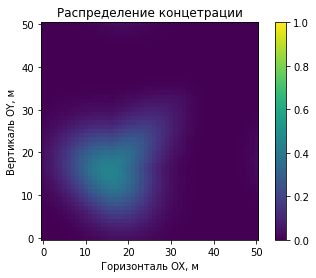

In [96]:
fig, ax = plt.subplots()
ax.set_title('Распределение концетрации')
_ = ax.set_xlabel('Горизонталь OX, м')
_ = ax.set_ylabel('Вертикаль OY, м')
img = ax.imshow(data_current['q'], vmin = 0, vmax = 1, origin = 'lower')
_ = fig.colorbar(img)